# TEMPO Gas Column plotting

## Summary

This notebook is to generate time series of total gas columns retrieved by TEMPO. It is using L2 data. User is supposed to select specific trace gas, period of time and points of interest.

## Prerequisites

- `earthaccess`
- `netCDF4`
- `numpy`
- `shapely`
- `scipy`

In [1]:
import os
import platform
from subprocess import Popen
import shutil

import earthaccess
import netCDF4 as nc
import numpy as np
from shapely.geometry import Point, Polygon
from scipy.interpolate import griddata

### Create EDL files using the `earthaccess`

First, pass your Earthdata credentials to the `earthaccess` library to create the `.netrc` file:

In [2]:
auth = earthaccess.login()

Select which gas column is needed

In [5]:
igas = 0

while igas > 3 or igas < 1:
    igas = int(
        input(
            "please enter trace gas of interest: 1 - ozone, 2 - nitrogen dioxide, 3 - formaldehyde: "
        )
    )

    if igas == 1:
        print("you selected ozone")
        main_path = (
            "https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_O3TOT_L2_V03/"
        )
        short_name = "TEMPO_O3TOT_L2"
        var_name = "column_amount_o3"
        out_Q = "tot_O3_col"  # name of the output quantity with unit
        out_Q_unit = out_Q + ",_DU"  # name of the output quantity with unit
    elif igas == 2:
        print("you selected nitrogen dioxide")
        main_path = (
            "https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L2_V03/"
        )
        short_name = "TEMPO_NO2_L2"
        var_name = "vertical_column_total"
        out_Q = "tot_NO2_col"  # name of the output quantity with unit
        out_Q_unit = out_Q + ",_mol/cm^2"  # name of the output quantity with unit
    elif igas == 3:
        print("you selected formaldehyde")
        main_path = (
            "https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/"
        )
        short_name = "TEMPO_HCHO_L2"
        var_name = "vertical_column"
        out_Q = "tot_HCHO_col"  # name of the output quantity
        out_Q_unit = out_Q + ",_mol/cm^2"  # name of the output quantity with unit
    else:
        print("your selection in incorrect, try again")

print("path to the data: ", main_path)

please enter trace gas of interest: 1 - ozone, 2 - nitrogen dioxide, 3 - formaldehyde:  3


you selected formaldehyde
path to the data:  https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/


Entering time frame of interest. Initial and final datestamps should be of the form "yyyymmdd"

In [6]:
date_test = False
while not date_test:
    try:
        datestamp_ini = input(
            "please enter beginning date, yyyymmdd, should be on or after 20231017: "
        )
        yyyy_ini = int(datestamp_ini[0:4])
        mm_ini = int(datestamp_ini[4:6])
        dd_ini = int(datestamp_ini[6:8])
    except Exception:
        print("cannot read initial date stamp, try again")
        continue

    try:
        datestamp_fin = input("please enter end date, yyyymmdd, should be on or after 20231017: ")
        yyyy_fin = int(datestamp_fin[0:4])
        mm_fin = int(datestamp_fin[4:6])
        dd_fin = int(datestamp_fin[6:8])
    except Exception:
        print("cannot read final date stamp, try again")
        continue

    if yyyy_fin < yyyy_ini:
        print("beginning date is after end date, try again")
        continue

    if yyyy_fin == yyyy_ini and mm_fin < mm_ini:
        print("beginning date is after end date, try again")
        continue

    if yyyy_fin == yyyy_ini and mm_fin == mm_ini and dd_fin < dd_ini:
        print("beginning date is after end date, try again")
        continue

    date_test = True

date_start = str("%4.4i-%2.2i-%2.2i 00:00:00" % (yyyy_ini, mm_ini, dd_ini))
date_end = str("%4.4i-%2.2i-%2.2i 23:59:59" % (yyyy_fin, mm_fin, dd_fin))

print(date_start, date_end)

please enter beginning date, yyyymmdd, should be on or after 20231017:  20231029
please enter end date, yyyymmdd, should be on or after 20231017:  20231102


2023-10-29 00:00:00 2023-11-02 23:59:59


Entering point of interest (POI) information.

Current version allows for only one POI. Future version will be extended to accept an arbitrary number of POIs.

In [7]:
# nPOIs = 1 # we consider only one POI here

POI_names = []
POI_lats = []
POI_lons = []

POI_test = False

while not POI_test:
    try:
        POI_name = input("please enter POI name: ")
        POI_lat = np.float64(
            input("please enter latitude of the POI, should be on in range -90 to 90 degrees: ")
        )
        if POI_lat > 90.0 or POI_lat < -90.0:
            print("cannot read POI latitude is out of range -90 to 90 degrees, try again")
            continue
        POI_lon = np.float64(
            input("please enter longitude of the POI, should be on in range -180 to 180 degrees: ")
        )
        if POI_lon > 180.0 or POI_lon < -180.0:
            print("cannot read POI latitude is out of range -180 to 180 degrees, try again")
            continue

        POI_names.append(POI_name)
        POI_lats.append(POI_lat)
        POI_lons.append(POI_lon)

        POI_Q = input("Would you like to enter another POI (y/n)? ")
        if POI_Q == "y":
            continue
        POI_test = True

    except Exception:
        print("cannot read POI information, try again")
        continue

nPOIs = len(POI_names)

POIs = np.empty([nPOIs, 2])
for i in range(nPOIs):
    POIs[i, 0] = POI_lats[i]
    POIs[i, 1] = POI_lons[i]

please enter POI name:  ManhattanNY-CCNY
please enter latitude of the POI, should be on in range -90 to 90 degrees:  40.8153
please enter longitude of the POI, should be on in range -180 to 180 degrees:  -73.9505
Would you like to enter another POI (y/n)?  y
please enter POI name:  Centro de Ciencias de la Atmosfera
please enter latitude of the POI, should be on in range -90 to 90 degrees:  19.3262
please enter longitude of the POI, should be on in range -180 to 180 degrees:  -99.1761
Would you like to enter another POI (y/n)?  n


In [8]:
results_all = []
POI_results = np.empty(nPOIs, dtype=object)
for i in range(nPOIs):
    POI_lat = POIs[i, 0]
    POI_lon = POIs[i, 1]

    bbox = (POI_lon - 0.5, POI_lat - 0.5, POI_lon + 0.5, POI_lat + 0.5)
    results = earthaccess.search_data(
        short_name=short_name, temporal=(date_start, date_end), bounding_box=bbox
    )
    POI_results[i] = results
    for result in results:
        if result in results_all:
            continue
        results_all.append(result)

print("total number of granules to download:", len(results_all))

total number of granules to download: 178


Though the type of the elements of the list results is <class 'earthaccess.results.DataGranule'>, they are dictionaries. As we saw, they contain a link to the granules at https://data.asdc.earthdata.nasa.gov/. Code below extracts these links. User may skip this stage unless explicit data links are needed. The granules will be downloaded with function earthaccess.download().

In [12]:
granule_links = []
for result in results_all:
    granule_links.append(result["umm"]["RelatedUrls"][0]["URL"])

# for granule_link in granule_links: print(granule_link)

In [9]:
downloaded_files = earthaccess.download(results_all, local_path="./")

In [14]:
last_slash_ind = granule_links[0].rfind("/")
# print(last_slash_ind)
fname = granule_links[0][last_slash_ind + 1 :]
print(fname)

with nc.Dataset(fname, persist=False) as ncf:

    print("file " + fname + " has been opened")
    print("**************\nprinting dimensions:\n")
    print(ncf.dimensions.keys())
    for d in ncf.dimensions.items():
        print(d)

    print("**************\nprinting variables:\n")
    print(ncf.variables.keys())
    for var in ncf.variables.items():
        print(var)
    
    print("**************\nprinting groups:\n")
    print(ncf.groups.keys())
    for group in ncf.groups.items():
        print(group)


TEMPO_HCHO_L2_V03_20231029T114836Z_S001G02.nc
file TEMPO_HCHO_L2_V03_20231029T114836Z_S001G02.nc has been opened
**************
printing dimensions:

dict_keys(['mirror_step', 'xtrack', 'corner', 'swt_level'])
('mirror_step', "<class 'netCDF4.Dimension'>": name = 'mirror_step', size = 131)
('xtrack', "<class 'netCDF4.Dimension'>": name = 'xtrack', size = 2048)
('corner', "<class 'netCDF4.Dimension'>": name = 'corner', size = 4)
('swt_level', "<class 'netCDF4.Dimension'>": name = 'swt_level', size = 72)
**************
printing variables:

dict_keys(['xtrack', 'mirror_step'])
('xtrack', <class 'netCDF4.Variable'>
int32 xtrack(xtrack)
    long_name: pixel index along slit
unlimited dimensions: 
current shape = (2048,)
filling on, default _FillValue of -2147483647 used)
('mirror_step', <class 'netCDF4.Variable'>
int32 mirror_step(mirror_step)
    long_name: scan mirror position index
unlimited dimensions: 
current shape = (131,)
filling on, default _FillValue of -2147483647 used)
*********

Below is the function we will use to read necessary arrays from TEMPO L2 granules.

**Important notice on the product issues:**

In order to search within the granule accurately, we need coordinates of the pixels' centers and corners. However, it was discovered that in multiple occasions pixels' polygons comprised by their corners do not contain their respective centers. For this reason, algorithm searching the POI within the granule was simplified. The simplified version only needs coordinates of the centers of the pixels. Consequently, the reading function below was also simplified. Original form can be easily restored by removing comments.


In [15]:
def read_TEMPO_L2(fn, var_name):
    """
    function read_TEMPO_L2 reads TEMPO L2 products
    TEMPO_O3TOT_L2_V03, column_amount_o3 or o3_below_cloud;
    TEMPO_HCHO_L2_V03, vertical_column;
    TEMPO_NO2_L2_V03, vertical_column_stratosphere, vertical_column_total, vertical_column_troposphere;
    and returns respective fields along with coordinates of the pixels and their corners
    and fill values of all variables.

    If requested variable cannot be read, all returned variables are zeroed
    """
    ds = nc.Dataset(fn)

    prod = ds.groups["product"]  # this opens group product, /product, as prod

    try:
        var = prod.variables[
            var_name
        ]  # this reads variable column_amount_o3 from prod (group product, /product)
    except Exception:
        print("variable " + var_name + " cannot be read in file " + fn)
        lat = 0.0
        lon = 0.0
        #    latb = 0. # un-comment this line to return to the original form of the function
        #    lonb = 0. # un-comment this line to return to the original form of the function
        time = 0.0
        fv_geo = 0.0
        var = 0.0
        fv_prod = 0.0
        #    return lat, lon, latb, lonb, fv_geo, time, var, fv_prod
        return (
            lat,
            lon,
            fv_geo,
            time,
            var,
            fv_prod,
        )  # remove or comment out this line and un-comment the line above to return to the original form of the function

    fv_prod = var.getncattr("_FillValue")
    prod_unit = var.getncattr("units")
    var = np.array(var)  # this converts variable column_amount_o3 into numpy array

    geo = ds.groups["geolocation"]  # this opens group geolocation, /geolocation, as geo

    lat = np.array(
        geo.variables["latitude"]
    )  # this reads variable latitude from geo (geolocation group, /geolocation) into a numpy array
    lon = np.array(
        geo.variables["longitude"]
    )  # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array
    fv_geo = geo.variables["latitude"].getncattr("_FillValue")
    time = np.array(
        geo.variables["time"]
    )  # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array

    #  latb = np.array(geo.variables['latitude_bounds']) # this reads variable latitude from geo into a numpy array
    #  lonb = np.array(geo.variables['longitude_bounds']) # this reads variable longitude from geo into a numpy array

    #  return lat, lon, latb, lonb, fv_geo, time, fv_geo, var, fv_prod, prod_unit
    return (
        lat,
        lon,
        fv_geo,
        time,
        var,
        fv_prod,
        prod_unit,
    )  # remove or comment out this line and un-comment the line above to return to the original form of the function

Provided with latitudes, longitudes, and their fill value, function below creates polygon of the granule, i.e. a list of locations of outer pixels of the granule. This is a simplified version taking coordinates of the centers of the pixels. More sophisticated version taking coordinates of the corners of the pixels will be supplied later, once the geometry problem, see above, is resolved.

Below is the second version of the polygon deriving algorithm, handling granules with complete scanlines filled with fill values.

Below is the second version of the polygon deriving algorithm

In [16]:
def TEMPO_L2_polygon(lat, lon, fv_geo):
    nx = lon.shape[0]
    ny = lon.shape[1]
    print(nx, ny)

    dpos = np.empty([0, 2])

    x_ind = np.empty([nx, ny], dtype=int)  # creating array in x indices
    for ix in range(nx):
        x_ind[ix, :] = ix  # populating array in x indices
    y_ind = np.empty([nx, ny], dtype=int)
    for iy in range(ny):
        y_ind[:, iy] = iy  # populating array in x indices

    mask = (lon[ix, iy] != fv_geo) & (lat[ix, iy] != fv_geo)
    if len(lon[mask]) == 0:
        print("the granule is empty - no meaningful positions")
        return dpos

    # right boundary
    r_m = min(x_ind[mask].flatten())
    local_mask = (lon[r_m, :] != fv_geo) & (lat[r_m, :] != fv_geo)
    r_b = np.stack((lon[r_m, local_mask], lat[r_m, local_mask])).T

    # left boundary
    l_m = max(x_ind[mask].flatten())
    local_mask = (lon[l_m, :] != fv_geo) & (lat[l_m, :] != fv_geo)
    l_b = np.stack((lon[l_m, local_mask], lat[l_m, local_mask])).T
    #  sys.exit()

    # top and bottom boundaries
    t_b = np.empty([0, 2])
    b_b = np.empty([0, 2])
    for ix in range(r_m + 1, l_m):
        local_mask = (lon[ix, :] != fv_geo) & (lat[ix, :] != fv_geo)
        local_y_ind = y_ind[ix, local_mask]
        y_ind_top = min(local_y_ind)
        y_ind_bottom = max(local_y_ind)
        t_b = np.append(t_b, [[lon[ix, y_ind_top], lat[ix, y_ind_top]]], axis=0)
        b_b = np.append(b_b, [[lon[ix, y_ind_bottom], lat[ix, y_ind_bottom]]], axis=0)

    # combining right, top, left, and bottom boundaries together, going along the combined boundary counterclockwise
    dpos = np.append(dpos, r_b[::-1, :], axis=0)  # this adds right boundary, counterclockwise
    dpos = np.append(dpos, t_b, axis=0)  # this adds top boundary, counterclockwise
    dpos = np.append(dpos, l_b, axis=0)  # this adds left boundary, counterclockwise
    dpos = np.append(dpos, b_b[::-1, :], axis=0)  # this adds bottom boundary, counterclockwise

    return dpos

To compile time series we will need to read the following arrays from individual granules:

group /geolocation:
    time, latitude, longitude

group /product:
    var_name (**ONE** of the following: column_amount_o3, vertical_column_total,vertical_column; see section on selection the trace gas of interest)

**Important comment on time:**

Since time is GPS time, i.e. seconds after GPS epoch (06 January 1980 00:00:00), we
would need to convert it to UTC, i.e. yyyy, mm, dd, hh, min, ss format. A code doing this can be used, however, we will employ the fact that the granule timestamp in the file name coincides with the time of the first scan line. Therefore, all we need to do is to add the difference between average time at the POI and the first sca line to the timestamp from the filename.

**Important comment on filtering out fill vaules and un-physical values:**
It was discovered that NO2 and formaldehyde total columns may be negative, though the values are not the fill values for these arrays. Pixels with negative columns may have various quality flags, including the highest quality. Since all gases columns have negative fill values, conditions below comparing variable of interest with its respective fill value are commented out and replaced by another condition requiring variable to be positive.

In the future if/when the problem of negative values is resolved (maybe with the help of accurate and more informative quality flags), the old conditions need to be restored.


In [25]:
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for ipos in range(nPOIs):
    POI_name = POI_names[ipos].replace(" ", "_")

    fout = open(
        out_Q
        + "_"
        + datestamp_ini
        + "_"
        + datestamp_fin
        + "_"
        + POI_name
        + "_"
        + str("%08.4fN_%08.4fW" % (POIs[ipos, 0], -POIs[ipos, 1])),
        "w",
    )
    fout.write(
        "timeseries of "
        + out_Q
        + " at "
        + POI_names[ipos]
        + "_"
        + str("%08.4fN_%08.4fW" % (POIs[ipos, 0], -POIs[ipos, 1]))
        + "\n"
    )
    fout.write("yyyy mm dd hh mn ss " + out_Q_unit + "\n")

    for result in POI_results[ipos]:
        granule_link = result.data_links(access="indirect")[0]
        last_slash_ind = granule_link.rfind("/")
        fname = granule_link[last_slash_ind + 1 :]
        print(fname)
        #    lat, lon, latb, lonb, fv_geo, time, var, fv_prod  = read_TEMPO_L2(fname, var_name)
        lat, lon, fv_geo, time, var, fv_prod, prod_unit = read_TEMPO_L2(
            fname, var_name
        )  # remove this line and un-comment the line above once the problem with pixels' corners and centers is resolved

        if isinstance(lat, float):
            continue

        print(fv_geo)
        # it appeared that garbage values of latitudes and longitudes in the L2 files are 9.969209968386869E36
        # while fill value is -1.2676506E30
        # (after deeper search it was found that actual values in the file is -1.2676506002282294E30).
        # For this reason, fv_geo is set to 9.96921E36 to make code working.
        # once the problem is resolved and garbage values of latitudes and longitudes equal to its fill value,
        # the line blow must be removed.
        if igas == 1:
            fv_geo = 9.969209968386869e36

        polygon = TEMPO_L2_polygon(lat, lon, fv_geo)
        print(polygon.shape)

        # self check the polygon, if the center of a pixel is outside the polygon, it is printed out
        coords_poly = list(polygon)
        poly = Polygon(coords_poly)

        nx = lon.shape[0]
        ny = lon.shape[1]

        # getting time from the granule filename
        Tind = fname.rfind("T")
        yyyy = int(fname[Tind - 8 : Tind - 4])
        mm = int(fname[Tind - 4 : Tind - 2])
        dd = int(fname[Tind - 2 : Tind])
        hh = int(fname[Tind + 1 : Tind + 3])
        mn = int(fname[Tind + 3 : Tind + 5])
        ss = float(fname[Tind + 5 : Tind + 7])

        # check whether POIs are in the granule. If ALL POIs are outside - move to the next granule
        pp = np.array([POIs[ipos, 1], POIs[ipos, 0]])
        p = Point(pp)  # POIs[:, 0] - latitudes, POIs[:, 1] - longitudes
        if not p.within(poly):
            continue
        print("point", p, "is in granule polygon")

        POI_found = False
        for ix in range(nx - 1):
            for iy in range(ny - 1):
                if lon[ix, iy] == fv_geo:
                    continue
                if lat[ix, iy] == fv_geo:
                    continue
                if lon[ix, iy + 1] == fv_geo:
                    continue
                if lat[ix, iy + 1] == fv_geo:
                    continue
                if lon[ix + 1, iy + 1] == fv_geo:
                    continue
                if lat[ix + 1, iy + 1] == fv_geo:
                    continue
                if lon[ix + 1, iy] == fv_geo:
                    continue
                if lat[ix + 1, iy] == fv_geo:
                    continue

                coords_poly_loc = [
                    [lon[ix, iy], lat[ix, iy]],
                    [lon[ix, iy + 1], lat[ix, iy + 1]],
                    [lon[ix + 1, iy + 1], lat[ix + 1, iy + 1]],
                    [lon[ix + 1, iy], lat[ix + 1, iy]],
                ]
                poly_loc = Polygon(coords_poly_loc)

                if p.within(poly_loc):
                    print(ix, iy, lat[ix, iy], lon[ix, iy], var[ix, iy])
                    print(ix, iy + 1, lat[ix, iy + 1], lon[ix, iy + 1], var[ix, iy + 1])
                    print(
                        ix + 1,
                        iy + 1,
                        lat[ix + 1, iy + 1],
                        lon[ix + 1, iy + 1],
                        var[ix + 1, iy + 1],
                    )
                    print(ix + 1, iy, lat[ix + 1, iy], lon[ix + 1, iy], var[ix + 1, iy])

                    POI_found = True
                    print(POIs[ipos, 1], POIs[ipos, 0], " found")

                    points = np.empty([0, 2])
                    ff = np.empty(0)

                    #          if var[ix, iy] != fv_prod:
                    if var[ix, iy] > 0.0:
                        points = np.append(points, [[lon[ix, iy], lat[ix, iy]]], axis=0)
                        ff = np.append(ff, var[ix, iy])

                    #          if var[ix, iy+1] != fv_prod:
                    if var[ix, iy + 1] > 0.0:
                        points = np.append(points, [[lon[ix, iy + 1], lat[ix, iy + 1]]], axis=0)
                        ff = np.append(ff, var[ix, iy + 1])

                    #          if var[ix+1, iy+1] != fv_prod:
                    if var[ix + 1, iy + 1] > 0.0:
                        points = np.append(
                            points, [[lon[ix + 1, iy + 1], lat[ix + 1, iy + 1]]], axis=0
                        )
                        ff = np.append(ff, var[ix + 1, iy + 1])

                    #          if var[ix+1, iy] != fv_prod:
                    if var[ix + 1, iy] > 0.0:
                        points = np.append(points, [[lon[ix + 1, iy], lat[ix + 1, iy]]], axis=0)
                        ff = np.append(ff, var[ix + 1, iy])

                    if ff.shape[0] == 0:
                        continue
                    elif ff.shape[0] < 4:
                        prod_loc = np.mean(ff)
                    elif ff.shape[0] == 4:
                        #            prod_loc = griddata(points, ff, p, method='linear', fill_value=-1., rescale=False)
                        prod_loc = griddata(
                            points, ff, pp, method="linear", fill_value=-1.0, rescale=False
                        )

                    if prod_loc > 0.0:
                        # handling time first:
                        delta_t = (time[ix + 1] + time[ix]) * 0.5 - time[0]
                        ss = ss + delta_t
                        if ss >= 60.0:
                            delta_mn = int(ss / 60.0)
                            ss = ss - 60.0 * delta_mn
                            mn = mn + delta_mn
                            if mn >= 60:
                                mn = mn - 60
                                hh = hh + 1
                                if hh == 24:
                                    hh = hh - 24
                                    dd = dd + 1
                                    day_month = days[mm]
                                    if (yyyy // 4) * 4 == yyyy and mm == 2:
                                        day_month = day_month + 1
                                    if dd > day_month:
                                        dd = 1
                                        mm = mm + 1
                                        if mm > 12:
                                            mm = 1
                                            yyyy = yyyy + 1

                        fout.write(
                            str(
                                "%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e "
                                % (yyyy, mm, dd, hh, mn, ss, prod_loc)
                            )
                        )
                        fout.write(
                            str("%9.4fN %9.4fW %10.3e " % (lat[ix, iy], -lon[ix, iy], var[ix, iy]))
                        )
                        fout.write(
                            str(
                                "%9.4fN %9.4fW %10.3e "
                                % (lat[ix, iy + 1], -lon[ix, iy + 1], var[ix, iy + 1])
                            )
                        )
                        fout.write(
                            str(
                                "%9.4fN %9.4fW %10.3e "
                                % (lat[ix + 1, iy + 1], -lon[ix + 1, iy + 1], var[ix + 1, iy + 1])
                            )
                        )
                        fout.write(
                            str(
                                "%9.4fN %9.4fW %10.3e\n"
                                % (lat[ix + 1, iy], -lon[ix + 1, iy], var[ix + 1, iy])
                            )
                        )

                    break

            if POI_found:
                break

    fout.close()

TEMPO_HCHO_L2_V03_20231029T114836Z_S001G02.nc
-1e+30
131 2048
(4354, 2)
TEMPO_HCHO_L2_V03_20231029T115513Z_S001G03.nc


/tmp/ipykernel_369066/3805147750.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  var = np.array(var)  # this converts variable column_amount_o3 into numpy array
/tmp/ipykernel_369066/3805147750.py:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  lat = np.array(
/tmp/ipykernel_369066/3805147750.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. T

-1e+30
131 2048
(4354, 2)
point POINT (-73.9505 40.8153) is in granule polygon
6 659 40.836075 -73.917496 -5.441989836284979e+16
6 660 40.815147 -73.92377 5.701774056214337e+16
7 660 40.81278 -73.98691 1.083448089459531e+17
7 659 40.83385 -73.980576 -2.0457256978166828e+16
-73.9505 40.8153  found
TEMPO_HCHO_L2_V03_20231029T122841Z_S002G02.nc
-1e+30
131 2048
(4354, 2)
TEMPO_HCHO_L2_V03_20231029T123518Z_S002G03.nc
-1e+30
131 2048
(4354, 2)
point POINT (-73.9505 40.8153) is in granule polygon
6 658 40.834328 -73.92211 2.9871514338679764e+16
6 659 40.81349 -73.92834 1.1682734471675416e+16
7 659 40.810955 -73.990746 6107385215993707.0
7 658 40.83196 -73.98444 8.756722395988496e+16
-73.9505 40.8153  found
TEMPO_HCHO_L2_V03_20231029T130846Z_S003G02.nc
-1e+30
131 2048
(4354, 2)
TEMPO_HCHO_L2_V03_20231029T131523Z_S003G03.nc


/tmp/ipykernel_369066/3611753397.py:182: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "%4.4i %2.2i %2.2i %2.2i %2.2i %2.2i %10.3e "


-1e+30
131 2048
(4354, 2)
point POINT (-73.9505 40.8153) is in granule polygon
6 658 40.823727 -73.93052 1.5701455934964728e+16
6 659 40.802708 -73.93686 3.982512355012335e+16
7 659 40.800407 -73.99915 9134157554333738.0
7 658 40.821484 -73.992805 8972856368312511.0
-73.9505 40.8153  found
TEMPO_HCHO_L2_V03_20231029T134851Z_S004G02.nc
-1e+30
131 2048
(4354, 2)
TEMPO_HCHO_L2_V03_20231029T135528Z_S004G03.nc
-1e+30
131 2048
(4354, 2)
point POINT (-73.9505 40.8153) is in granule polygon
6 659 40.816883 -73.912346 1.597784487239202e+16
6 660 40.795933 -73.91865 1.6721718387436874e+16
7 660 40.7945 -73.981026 1.1703658586195442e+16
7 659 40.815395 -73.97479 2.6475825598965156e+16
-73.9505 40.8153  found
TEMPO_HCHO_L2_V03_20231029T142856Z_S005G02.nc
-1e+30
132 2048
(4356, 2)
TEMPO_HCHO_L2_V03_20231029T143536Z_S005G03.nc
-1e+30
131 2048
(4354, 2)
point POINT (-73.9505 40.8153) is in granule polygon
5 658 40.828403 -73.91115 3.1079550970075996e+16
5 659 40.80746 -73.91745 2.582884093564815e+16


# Reading the output file and plotting the results

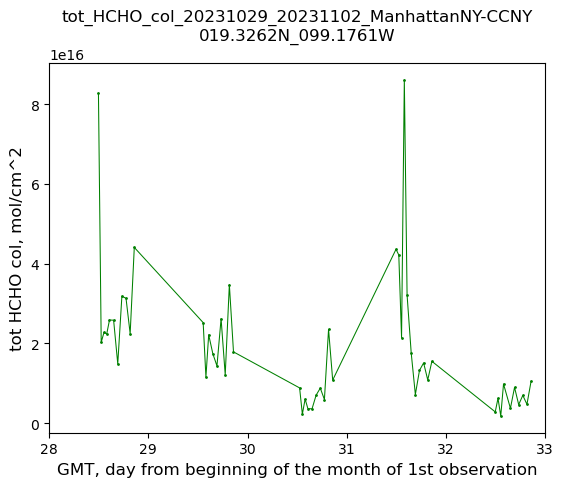

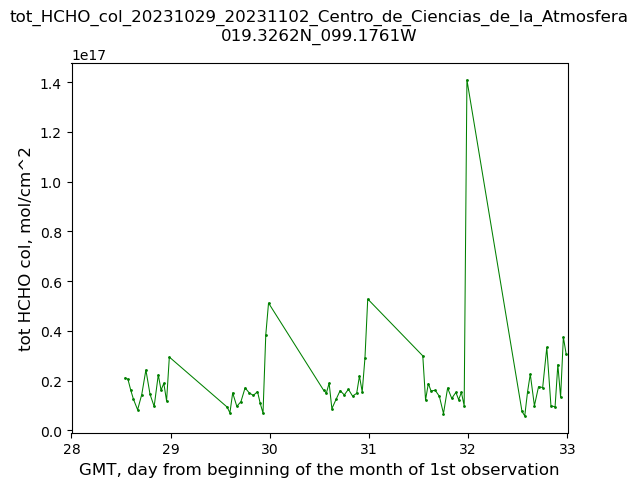

In [26]:
import matplotlib.pyplot as plt
from datetime import datetime

for ipos in range(nPOIs):
    POI_name = POI_names[ipos].replace(" ", "_")
    fout = open(
        out_Q
        + "_"
        + datestamp_ini
        + "_"
        + datestamp_fin
        + "_"
        + POI_name
        + "_"
        + str("%08.4fN_%08.4fW" % (POIs[ipos, 0], -POIs[ipos, 1])),
        "r",
    )
    lines = fout.readlines()
    fout.close()

    n_data = len(lines) - 2

    split = lines[2].split()
    yyyy = int(split[0])
    mm = int(split[1])
    dd = 1
    hh = 0
    mn = 0
    ss = 0
    dt0 = datetime(yyyy, mm, dd, hh, mn, ss)

    time_series = np.empty([n_data, 2])

    j = -1
    for line in lines[2:]:
        split = line.split()
        yyyy = int(split[0])
        mm = int(split[1])
        dd = int(split[2])
        hh = int(split[3])
        mn = int(split[4])
        ss = int(split[5])
        dt = datetime(yyyy, mm, dd, hh, mn, ss)
        j += 1
        time_series[j, 0] = (dt - dt0).total_seconds() / 86400.0  # time difference in hours
        time_series[j, 1] = float(split[6])

    plot_title = out_Q + "_" + datestamp_ini + "_" + datestamp_fin + "_" + POI_name

    fig, ax = plt.subplots()

    (plots,) = ax.plot(
        time_series[:, 0],
        time_series[:, 1],
        marker=".",
        markersize=2,
        linestyle="-",
        linewidth=0.75,
        color="g",
    )

    # Set the range of x-axis
    l_lim = int(min(time_series[:, 0]))
    u_lim = int(max(time_series[:, 0])) + 1
    plt.xlim(l_lim, u_lim)

    # Set the range of y-axis.
    # This is currently set only for ozone
    # other gases require some research to set their ranges
    if igas == 1:
        plt.ylim(225, 375)

    ax.set_xlabel(r"GMT, day from beginning of the month of 1st observation", fontsize=12)
    ax.set_ylabel(out_Q_unit.replace("_", " "), fontsize=12)

    plt.title(plot_title + str("\n%08.4fN_%08.4fW" % (POIs[i, 0], -POIs[i, 1])))
    img_name = plot_title + ".jpg"

    plt.show()
    # plt.savefig(img_name, format="jpg", dpi=300)
    # plt.close(fig)